# 1. Introduction

This project is the third assignment in the course - Machine Learning with Python-From Linear Models to Deep Learning by MITx. This course is part of the MITx MicroMasters Program in Statistics and Data Science. For further details, please visit (https://www.edx.org/course/machine-learning-with-python-from-linear-models-to).

The goal of this project is to implement neural networks to solve the digit recognition problem. In adition to MNIST, we will also deal with an overlapping multi-digit problem this time.

**MNIST:**
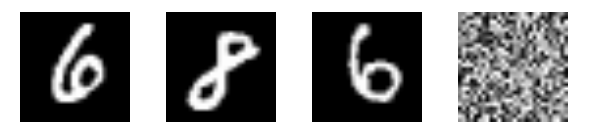

**Overlapping multi-digit:**
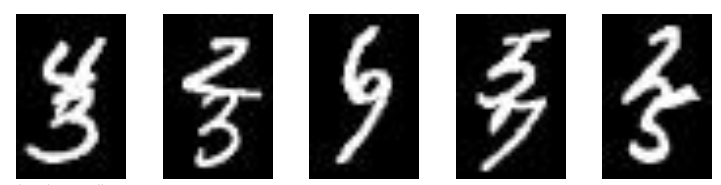

# 2. Classification for MNIST using deep neural networks

In this section, we are going to use deep neural networks to perform the same classification task with Pytorch. First, we will employ the most basic form of a deep neural network, in which the neurons in adjacent layers are fully connected to one another. Let's begin with the helper functions.

In [35]:
import _pickle as cPickle, gzip
import numpy as np
from tqdm import tqdm
import torch
import torch.autograd as autograd
import torch.nn.functional as F
import torch.nn as nn
import sys
sys.path.append("..")

In [36]:
# Getting MNIST data

def get_MNIST_data():
    """
    Reads mnist dataset from file

    Returns:
        train_x - 2D Numpy array (n, d) where each row is an image
        train_y - 1D Numpy array (n, ) where each row is a label
        test_x  - 2D Numpy array (n, d) where each row is an image
        test_y  - 1D Numpy array (n, ) where each row is a label

    """
    train_set, valid_set, test_set = read_pickle_data('mnist.pkl.gz')
    train_x, train_y = train_set
    valid_x, valid_y = valid_set
    train_x = np.vstack((train_x, valid_x))
    train_y = np.append(train_y, valid_y)
    test_x, test_y = test_set
    return (train_x, train_y, test_x, test_y)

def load_train_and_test_pickle(file_name):
    train_x, train_y, test_x, test_y = read_pickle_data(file_name)
    return train_x, train_y, test_x, test_y

In [37]:
# Helper for mini-batch gradient descent

def batchify_data(x_data, y_data, batch_size):
    """Takes a set of data points and labels and groups them into batches."""
    # Only take batch_size chunks (i.e. drop the remainder)
    N = int(len(x_data) / batch_size) * batch_size
    batches = []
    for i in range(0, N, batch_size):
        batches.append({
            'x': torch.tensor(x_data[i:i+batch_size], dtype=torch.float32),
            'y': torch.tensor(y_data[i:i+batch_size], dtype=torch.long
        )})
    return batches

In [38]:
# Training Procedure

def train_model(train_data, dev_data, model, lr=0.01, momentum=0.9, nesterov=False, n_epochs=30):
    """Train a model for N epochs given data and hyper-params."""
    # We optimize with SGD
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=nesterov)

    for epoch in range(1, 11):
        print("-------------\nEpoch {}:\n".format(epoch))


        # Run **training***
        loss, acc = run_epoch(train_data, model.train(), optimizer)
        print('Train loss: {:.6f} | Train accuracy: {:.6f}'.format(loss, acc))

        # Run **validation**
        val_loss, val_acc = run_epoch(dev_data, model.eval(), optimizer)
        print('Val loss:   {:.6f} | Val accuracy:   {:.6f}'.format(val_loss, val_acc))
        # Save model
        torch.save(model, 'mnist_model_fully_connected.pt')
    return val_acc

In [39]:
def run_epoch(data, model, optimizer):
    """Train model for one pass of train data, and return loss, acccuracy"""
    # Gather losses
    losses = []
    batch_accuracies = []

    # If model is in train mode, use optimizer.
    is_training = model.training

    # Iterate through batches
    for batch in tqdm(data):
        # Grab x and y
        x, y = batch['x'], batch['y']

        # Get output predictions
        out = model(x)

        # Predict and store accuracy
        predictions = torch.argmax(out, dim=1)
        batch_accuracies.append(compute_accuracy(predictions, y))

        # Compute loss
        loss = F.cross_entropy(out, y)
        losses.append(loss.data.item())

        # If training, do an update.
        if is_training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Calculate epoch level scores
    avg_loss = np.mean(losses)
    avg_accuracy = np.mean(batch_accuracies)
    return avg_loss, avg_accuracy

In [40]:
def compute_accuracy(predictions, y):
    """Computes the accuracy of predictions against the gold labels, y."""
    return np.mean(np.equal(predictions.numpy(), y.numpy()))

# 3. Fully-Connected Neural Networks

We will employ the most basic form of a deep neural network, in which the neurons in adjacent layers are fully connected to one another.

### Training and Testing Accuracy Over Time

Implement a simple neural network with below properties:
- One hidden layer of 10 neurons with a rectified linear unit (ReLU) nonlinearity, as well as an output layer of 10 neurons (one for each digit class). 
- A softmax function normalizes the activations of the output neurons so that they specify a probability distribution. 
- Train the network with 10 epochs, where an epoch is a complete pass through the training dataset. 
- Total training time of your network should take no more than a couple of minutes. At the end of training, the model should have an accuracy of more than 85% on test data.

In [26]:
# Baseline model

def main():
    # Load the dataset
    num_classes = 10
    X_train, y_train, X_test, y_test = get_MNIST_data()

    # Split into train and dev
    dev_split_index = int(9 * len(X_train) / 10)
    X_dev = X_train[dev_split_index:]
    y_dev = y_train[dev_split_index:]
    X_train = X_train[:dev_split_index]
    y_train = y_train[:dev_split_index]

    permutation = np.array([i for i in range(len(X_train))])
    np.random.shuffle(permutation)
    X_train = [X_train[i] for i in permutation]
    y_train = [y_train[i] for i in permutation]

    # Split dataset into batches
    batch_size = 32
    train_batches = batchify_data(X_train, y_train, batch_size)
    dev_batches = batchify_data(X_dev, y_dev, batch_size)
    test_batches = batchify_data(X_test, y_test, batch_size)

    #################################
    model = nn.Sequential(
              nn.Linear(784, 10),
              nn.ReLU(),
              nn.Linear(10, 10),
            )
    lr=0.1
    momentum=0
    ##################################

    train_model(train_batches, dev_batches, model, lr=lr, momentum=momentum)

    ## Evaluate the model on test data
    loss, accuracy = run_epoch(test_batches, model.eval(), None)

    print ("Loss on test set:"  + str(loss) + " Accuracy on test set: " + str(accuracy))

In [27]:
if __name__ == '__main__':
    np.random.seed(12321)  # for reproducibility
    torch.manual_seed(12321)  # for reproducibility
    main()

  2%|▏         | 34/1687 [00:00<00:04, 337.86it/s]

-------------
Epoch 1:



  0%|          | 0/1687 [00:00<?, ?it/s]

Train loss: 0.445684 | Train accuracy: 0.870758
Val loss:   0.260342 | Val accuracy:   0.923630
-------------
Epoch 2:



  0%|          | 0/1687 [00:00<?, ?it/s]

Train loss: 0.303323 | Train accuracy: 0.912289
Val loss:   0.239971 | Val accuracy:   0.929479
-------------
Epoch 3:



  0%|          | 0/1687 [00:00<?, ?it/s]

Train loss: 0.281178 | Train accuracy: 0.918920
Val loss:   0.232849 | Val accuracy:   0.932152
-------------
Epoch 4:



  1%|          | 20/1687 [00:00<00:08, 193.50it/s]

Train loss: 0.266577 | Train accuracy: 0.923088
Val loss:   0.231824 | Val accuracy:   0.930983
-------------
Epoch 5:



  2%|▏         | 33/1687 [00:00<00:05, 328.84it/s]

Train loss: 0.255165 | Train accuracy: 0.926460
Val loss:   0.230423 | Val accuracy:   0.931317
-------------
Epoch 6:



  1%|          | 14/1687 [00:00<00:12, 138.95it/s]

Train loss: 0.245930 | Train accuracy: 0.928442
Val loss:   0.229930 | Val accuracy:   0.931150
-------------
Epoch 7:



  0%|          | 0/1687 [00:00<?, ?it/s]

Train loss: 0.238349 | Train accuracy: 0.930702
Val loss:   0.231337 | Val accuracy:   0.930648
-------------
Epoch 8:



  6%|▌         | 101/1687 [00:00<00:01, 1003.28it/s]

Train loss: 0.232549 | Train accuracy: 0.932276
Val loss:   0.229597 | Val accuracy:   0.932487
-------------
Epoch 9:



  0%|          | 0/1687 [00:00<?, ?it/s]

Train loss: 0.227751 | Train accuracy: 0.933888
Val loss:   0.229607 | Val accuracy:   0.932487
-------------
Epoch 10:



 79%|███████▉  | 248/312 [00:00<00:00, 2475.07it/s]

Train loss: 0.223966 | Train accuracy: 0.935147
Val loss:   0.228388 | Val accuracy:   0.932487


100%|██████████| 312/312 [00:00<00:00, 2313.17it/s]


Loss on test set:0.2672269511079857 Accuracy on test set: 0.9204727564102564


### Improving Accuracy

Playing around with the hyper parameters (batch size, learning rate, momentum, activation function), tunning the network with 128 hidden representation size and Leakly ReLU activation function achieves the highest both validation and test accuracy as below shown.

In [42]:
# LeakyReLU activation, hidden representation size = 128
# This model has the best Val accuracy AND Test Accuracy

def main():
    # Load the dataset
    num_classes = 10
    X_train, y_train, X_test, y_test = get_MNIST_data()

    # Split into train and dev
    dev_split_index = int(9 * len(X_train) / 10)
    X_dev = X_train[dev_split_index:]
    y_dev = y_train[dev_split_index:]
    X_train = X_train[:dev_split_index]
    y_train = y_train[:dev_split_index]

    permutation = np.array([i for i in range(len(X_train))])
    np.random.shuffle(permutation)
    X_train = [X_train[i] for i in permutation]
    y_train = [y_train[i] for i in permutation]

    # Split dataset into batches
    batch_size = 32
    train_batches = batchify_data(X_train, y_train, batch_size)
    dev_batches = batchify_data(X_dev, y_dev, batch_size)
    test_batches = batchify_data(X_test, y_test, batch_size)

    #################################
    model = nn.Sequential(
              nn.Linear(784, 128),
              nn.LeakyReLU(),
              nn.Linear(128, 10),
            )
    lr=0.1
    momentum=0
    ##################################

    train_model(train_batches, dev_batches, model, lr=lr, momentum=momentum)

    ## Evaluate the model on test data
    loss, accuracy = run_epoch(test_batches, model.eval(), None)

    print ("Loss on test set:"  + str(loss) + " Accuracy on test set: " + str(accuracy))

In [43]:
if __name__ == '__main__':
    np.random.seed(12321)  # for reproducibility
    torch.manual_seed(12321)  # for reproducibility
    main()

  7%|▋         | 117/1687 [00:00<00:02, 575.63it/s]

-------------
Epoch 1:



  0%|          | 0/1687 [00:00<?, ?it/s]

Train loss: 0.366999 | Train accuracy: 0.897044
Val loss:   0.179367 | Val accuracy:   0.947861
-------------
Epoch 2:



  0%|          | 0/1687 [00:00<?, ?it/s]

Train loss: 0.175310 | Train accuracy: 0.948818
Val loss:   0.126358 | Val accuracy:   0.965575
-------------
Epoch 3:



 32%|███▏      | 59/187 [00:00<00:00, 585.74it/s]

Train loss: 0.123106 | Train accuracy: 0.965323


  0%|          | 0/1687 [00:00<?, ?it/s]

Val loss:   0.103982 | Val accuracy:   0.970421
-------------
Epoch 4:



  0%|          | 0/1687 [00:00<?, ?it/s]

Train loss: 0.095496 | Train accuracy: 0.973122
Val loss:   0.091798 | Val accuracy:   0.973095
-------------
Epoch 5:



  0%|          | 0/1687 [00:00<?, ?it/s]

Train loss: 0.077687 | Train accuracy: 0.978049
Val loss:   0.084811 | Val accuracy:   0.975769
-------------
Epoch 6:



  0%|          | 0/1687 [00:00<?, ?it/s]

Train loss: 0.065045 | Train accuracy: 0.982013
Val loss:   0.080064 | Val accuracy:   0.977440
-------------
Epoch 7:



  0%|          | 0/1687 [00:00<?, ?it/s]

Train loss: 0.055322 | Train accuracy: 0.985033
Val loss:   0.076385 | Val accuracy:   0.977440
-------------
Epoch 8:



 21%|██        | 39/187 [00:00<00:00, 388.11it/s]

Train loss: 0.047539 | Train accuracy: 0.987033


  1%|          | 13/1687 [00:00<00:15, 109.80it/s]

Val loss:   0.074189 | Val accuracy:   0.977774
-------------
Epoch 9:



  0%|          | 0/1687 [00:00<?, ?it/s]

Train loss: 0.040982 | Train accuracy: 0.989126
Val loss:   0.073025 | Val accuracy:   0.978610
-------------
Epoch 10:



 43%|████▎     | 80/187 [00:00<00:00, 786.03it/s]

Train loss: 0.035379 | Train accuracy: 0.990997


 20%|██        | 63/312 [00:00<00:00, 628.72it/s]

Val loss:   0.071347 | Val accuracy:   0.979111


100%|██████████| 312/312 [00:00<00:00, 437.68it/s]

Loss on test set:0.07423398407300762 Accuracy on test set: 0.9772636217948718


# 4. Convolutional Neural Networks

Apply convolutional neural networks to the same task. These networks have demonstrated great performance on many deep learning tasks, especially in computer vision.

Using the [PyTorch Documentation](https://pytorch.org/docs/stable/index.html), complete the code to implement a convolutional neural network with following layers in order:

- A convolutional layer with 32 filters of size  3×3 

- A ReLU nonlinearity

- A max pooling layer with size  2×2 

- A convolutional layer with 64 filters of size  3×3 

- A ReLU nonlinearity

- A max pooling layer with size  2×2 

- A flatten layer

- A fully connected layer with 128 neurons

- A dropout layer with drop probability 0.5

- A fully-connected layer with 10 neurons

In [44]:
class Flatten(nn.Module):
    """A custom layer that views an input as 1D."""

    def forward(self, input):
        return input.view(input.size(0), -1)

In [46]:
def main():
    # Load the dataset
    num_classes = 10
    X_train, y_train, X_test, y_test = get_MNIST_data()

    # We need to rehape the data back into a 1x28x28 image
    X_train = np.reshape(X_train, (X_train.shape[0], 1, 28, 28))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, 28, 28))

    # Split into train and dev
    dev_split_index = int(9 * len(X_train) / 10)
    X_dev = X_train[dev_split_index:]
    y_dev = y_train[dev_split_index:]
    X_train = X_train[:dev_split_index]
    y_train = y_train[:dev_split_index]

    permutation = np.array([i for i in range(len(X_train))])
    np.random.shuffle(permutation)
    X_train = [X_train[i] for i in permutation]
    y_train = [y_train[i] for i in permutation]

    # Split dataset into batches
    batch_size = 32
    train_batches = batchify_data(X_train, y_train, batch_size)
    dev_batches = batchify_data(X_dev, y_dev, batch_size)
    test_batches = batchify_data(X_test, y_test, batch_size)

    #################################
    model = nn.Sequential(
                nn.Conv2d(1, 32, (3, 3)),
                nn.ReLU(),
                nn.MaxPool2d((2, 2)),
                nn.Conv2d(32, 64, (3, 3)),
                nn.ReLU(),
                nn.MaxPool2d((2, 2)),
                Flatten(),
                nn.Linear(1600, 128),
                nn.Dropout(),
                nn.Linear(128, 10)
                
            )
    ##################################

    train_model(train_batches, dev_batches, model, nesterov=True)

    ## Evaluate the model on test data
    loss, accuracy = run_epoch(test_batches, model.eval(), None)

    print ("Loss on test set:"  + str(loss) + " Accuracy on test set: " + str(accuracy))

In [47]:
if __name__ == '__main__':
    # Specify seed for deterministic behavior, then shuffle.
    np.random.seed(12321)  # for reproducibility
    torch.manual_seed(12321)
    main()

  0%|          | 0/1687 [00:00<?, ?it/s]

-------------
Epoch 1:



  6%|▌         | 11/187 [00:00<00:01, 103.21it/s]

Train loss: 0.243935 | Train accuracy: 0.923644


  0%|          | 4/1687 [00:00<00:46, 36.00it/s]

Val loss:   0.059677 | Val accuracy:   0.983289
-------------
Epoch 2:



  3%|▎         | 6/187 [00:00<00:03, 47.81it/s]

Train loss: 0.077967 | Train accuracy: 0.976623


  0%|          | 3/1687 [00:00<01:11, 23.71it/s]

Val loss:   0.043072 | Val accuracy:   0.988135
-------------
Epoch 3:



  4%|▎         | 7/187 [00:00<00:02, 69.29it/s]

Train loss: 0.057449 | Train accuracy: 0.982699


  0%|          | 4/1687 [00:00<00:53, 31.69it/s]

Val loss:   0.041951 | Val accuracy:   0.987634
-------------
Epoch 4:



  4%|▍         | 8/187 [00:00<00:02, 79.82it/s]

Train loss: 0.045141 | Train accuracy: 0.986477


  0%|          | 2/1687 [00:00<01:27, 19.26it/s]

Val loss:   0.034828 | Val accuracy:   0.989138
-------------
Epoch 5:



  4%|▎         | 7/187 [00:00<00:02, 69.39it/s]

Train loss: 0.039297 | Train accuracy: 0.988126


  0%|          | 3/1687 [00:00<01:06, 25.51it/s]

Val loss:   0.033864 | Val accuracy:   0.989806
-------------
Epoch 6:



  4%|▍         | 8/187 [00:00<00:02, 76.97it/s]

Train loss: 0.033323 | Train accuracy: 0.989256


  0%|          | 1/1687 [00:00<03:03,  9.18it/s]

Val loss:   0.036560 | Val accuracy:   0.988803
-------------
Epoch 7:



  5%|▌         | 10/187 [00:00<00:01, 91.29it/s]

Train loss: 0.028733 | Train accuracy: 0.991053


  0%|          | 3/1687 [00:00<01:12, 23.33it/s]

Val loss:   0.038710 | Val accuracy:   0.988469
-------------
Epoch 8:



  5%|▍         | 9/187 [00:00<00:02, 84.68it/s]

Train loss: 0.025445 | Train accuracy: 0.991553


  0%|          | 2/1687 [00:00<01:42, 16.46it/s]

Val loss:   0.032155 | Val accuracy:   0.990642
-------------
Epoch 9:



  4%|▍         | 8/187 [00:00<00:02, 72.90it/s]

Train loss: 0.022794 | Train accuracy: 0.992757


  0%|          | 3/1687 [00:00<01:02, 26.88it/s]

Val loss:   0.036237 | Val accuracy:   0.990976
-------------
Epoch 10:



  3%|▎         | 5/187 [00:00<00:04, 43.14it/s]

Train loss: 0.020207 | Train accuracy: 0.993424


  2%|▏         | 5/312 [00:00<00:06, 48.06it/s]

Val loss:   0.034969 | Val accuracy:   0.991310


100%|██████████| 312/312 [00:04<00:00, 65.27it/s]


Loss on test set:0.028314275372041973 Accuracy on test set: 0.9906850961538461


# 5. Overlapping, multi-digit MNIST

In this problem, we are going to go beyond the basic MNIST. Train a few neural networks to solve the problem of hand-written digit recognition using a multi-digit version of MNIST.

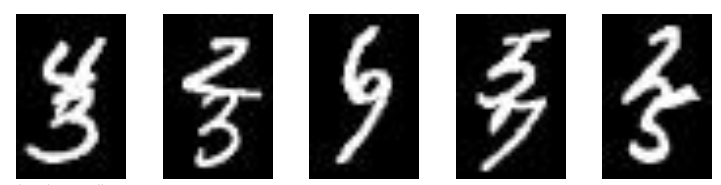

In [79]:
num_classes = 10
img_rows, img_cols = 42, 28
path_to_data_dir = '/Datasets/'

def get_data(path_to_data_dir, use_mini_dataset):
    if use_mini_dataset:
        exten = '_mini'
    else:
        exten = ''
    f = gzip.open('train_multi_digit' + exten + '.pkl.gz', 'rb')
    X_train = _pickle.load(f, encoding='latin1')
    f.close()
    X_train =  np.reshape(X_train, (len(X_train), 1, img_rows, img_cols))
    f = gzip.open('test_multi_digit' + exten +'.pkl.gz', 'rb')
    X_test = _pickle.load(f, encoding='latin1')
    f.close()
    X_test =  np.reshape(X_test, (len(X_test),1, img_rows, img_cols))
    f = gzip.open('train_labels' + exten +'.txt.gz', 'rb')
    y_train = np.loadtxt(f)
    f.close()
    f = gzip.open('test_labels' + exten + '.txt.gz', 'rb')
    y_test = np.loadtxt(f)
    f.close()
    return X_train, y_train, X_test, y_test

### Fully connected network

Build a fully-connected model with a single hidden layer with 64 units. Make use of `Linear` layers in PyTorch with flatten function. Also note that the model must have two outputs (corresponding to the first and second digits) to be compatible with the data.

In [59]:
class MLP(nn.Module):

    def __init__(self, input_dimension):
        super(MLP, self).__init__()
        self.flatten = Flatten()
        self.input_linear = nn.Linear(input_dimension, 64)
        self.output_linear = nn.Linear(64, 20)

    def forward(self, x):
        xf = self.flatten(x)
        xf = self.input_linear(xf)
        xf = self.output_linear(xf)
        out_first_digit = xf[:,:10]
        out_second_digit = xf[:,10:]

        return out_first_digit, out_second_digit

### Convolutional model

Make use of Conv2D layers and MaxPool2d layers (and perhaps Dropout) in PyTorch to build a convolutional model. Make sure that the last layer of the neural network is a fully connected (Linear) layer.

In [90]:
# Training utilities for CNN

def batchify_data(x_data, y_data, batch_size):
    """Takes a set of data points and labels and groups them into batches."""
    # Only take batch_size chunks (i.e. drop the remainder)
    N = int(len(x_data) / batch_size) * batch_size
    batches = []
    for i in range(0, N, batch_size):
        batches.append({
            'x': torch.tensor(x_data[i:i+batch_size], dtype=torch.float32),
            'y': torch.tensor([y_data[0][i:i + batch_size], y_data[1][i:i + batch_size]], dtype=torch.int64)
        })
    return batches

def compute_accuracy(predictions, y):
    """Computes the accuracy of predictions against the gold labels, y."""
    return np.mean(np.equal(predictions.numpy(), y.numpy()))


# Training Procedure
def train_model(train_data, dev_data, model, lr=0.01, momentum=0.9, nesterov=False, n_epochs=30):
    """Train a model for N epochs given data and hyper-params."""
    # We optimize with SGD
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=nesterov)

    for epoch in range(1, 11):
        print("-------------\nEpoch {}:\n".format(epoch))

        # Run **training***
        loss, acc = run_epoch(train_data, model.train(), optimizer)
        print('Train | loss1: {:.6f}  accuracy1: {:.6f} | loss2: {:.6f}  accuracy2: {:.6f}'.format(loss[0], acc[0], loss[1], acc[1]))
        
        # Run **validation**
        val_loss, val_acc = run_epoch(dev_data, model.eval(), optimizer)
        print('Valid | loss1: {:.6f}  accuracy1: {:.6f} | loss2: {:.6f}  accuracy2: {:.6f}'.format(val_loss[0], val_acc[0], val_loss[1], val_acc[1]))
        
        # Save model
        torch.save(model, 'mnist_model_fully_connected.pt')
    return val_acc

def run_epoch(data, model, optimizer):
    """Train model for one pass of train data, and return loss, acccuracy"""
    # Gather losses
    losses_first_label = []
    losses_second_label = []
    batch_accuracies_first = []
    batch_accuracies_second = []

    # If model is in train mode, use optimizer.
    is_training = model.training

    # Iterate through batches
    for batch in tqdm(data):
        # Grab x and y
        x, y = batch['x'], batch['y']

        # Get output predictions for both the upper and lower numbers
        out1, out2 = model(x)

        # Predict and store accuracy
        predictions_first_label = torch.argmax(out1, dim=1)
        predictions_second_label = torch.argmax(out2, dim=1)
        batch_accuracies_first.append(compute_accuracy(predictions_first_label, y[0]))
        batch_accuracies_second.append(compute_accuracy(predictions_second_label, y[1]))

        # Compute both losses
        loss1 = F.cross_entropy(out1, y[0])
        loss2 = F.cross_entropy(out2, y[1])
        losses_first_label.append(loss1.data.item())
        losses_second_label.append(loss2.data.item())

        # If training, do an update.
        if is_training:
            optimizer.zero_grad()
            joint_loss = 0.5 * (loss1 + loss2)
            joint_loss.backward()
            optimizer.step()

    # Calculate epoch level scores
    avg_loss = np.mean(losses_first_label), np.mean(losses_second_label)
    avg_accuracy = np.mean(batch_accuracies_first), np.mean(batch_accuracies_second)
    return avg_loss, avg_accuracy

In [91]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import utils_multiMNIST as U
path_to_data_dir = '/Datasets/'
use_mini_dataset = True

batch_size = 64
nb_classes = 10
nb_epoch = 30
num_classes = 10
img_rows, img_cols = 42, 28 # input image dimensions



class CNN(nn.Module):

    def __init__(self, input_dimension):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 4)
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32, 64, 4)
        self.pool2 = nn.MaxPool2d(2,2)
        self.flatten = Flatten()
        self.input_linear = nn.Linear(2048, 128)
        self.dropout = nn.Dropout()
        self.output_linear = nn.Linear(128, 20)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.flatten(x)        
        x = F.relu(self.input_linear(x))
        x = self.dropout(x)
        x = self.output_linear(x)
        out_first_digit = x[:,:10]
        out_second_digit = x[:,10:]

        return out_first_digit, out_second_digit

def main():
    X_train, y_train, X_test, y_test = get_data(path_to_data_dir, use_mini_dataset)

    # Split into train and dev
    dev_split_index = int(9 * len(X_train) / 10)
    X_dev = X_train[dev_split_index:]
    y_dev = [y_train[0][dev_split_index:], y_train[1][dev_split_index:]]
    X_train = X_train[:dev_split_index]
    y_train = [y_train[0][:dev_split_index], y_train[1][:dev_split_index]]

    permutation = np.array([i for i in range(len(X_train))])
    np.random.shuffle(permutation)
    X_train = [X_train[i] for i in permutation]
    y_train = [[y_train[0][i] for i in permutation], [y_train[1][i] for i in permutation]]

    # Split dataset into batches
    train_batches = batchify_data(X_train, y_train, batch_size)
    dev_batches = batchify_data(X_dev, y_dev, batch_size)
    test_batches = batchify_data(X_test, y_test, batch_size)

    # Load model
    input_dimension = img_rows * img_cols
    model = CNN(input_dimension)

    # Train
    train_model(train_batches, dev_batches, model)

    ## Evaluate the model on test data
    loss, acc = run_epoch(test_batches, model.eval(), None)
    print('Test loss1: {:.6f}  accuracy1: {:.6f}  loss2: {:.6f}   accuracy2: {:.6f}'.format(loss[0], acc[0], loss[1], acc[1]))

if __name__ == '__main__':
    np.random.seed(12321)  # for reproducibility
    torch.manual_seed(12321)  # for reproducibility
    main()

<ipython-input-90-3eab765bea3e>:25: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  'y': torch.tensor([y_data[0][i:i + batch_size], y_data[1][i:i + batch_size]], dtype=torch.int64)
  0%|          | 1/562 [00:00<01:39,  5.66it/s]

-------------
Epoch 1:



  3%|▎         | 2/62 [00:00<00:03, 19.09it/s]

Train | loss1: 1.026755  accuracy1: 0.647103 | loss2: 1.085454  accuracy2: 0.619078


  0%|          | 1/562 [00:00<01:14,  7.58it/s]

Valid | loss1: 0.244042  accuracy1: 0.927419 | loss2: 0.309369  accuracy2: 0.910030
-------------
Epoch 2:



  5%|▍         | 3/62 [00:00<00:02, 24.40it/s]

Train | loss1: 0.331971  accuracy1: 0.895463 | loss2: 0.419900  accuracy2: 0.856928


  0%|          | 1/562 [00:00<01:17,  7.22it/s]

Valid | loss1: 0.160107  accuracy1: 0.953881 | loss2: 0.190305  accuracy2: 0.942036
-------------
Epoch 3:



  5%|▍         | 3/62 [00:00<00:02, 25.44it/s]

Train | loss1: 0.237747  accuracy1: 0.926657 | loss2: 0.307131  accuracy2: 0.898827


  0%|          | 1/562 [00:00<01:15,  7.46it/s]

Valid | loss1: 0.125382  accuracy1: 0.960181 | loss2: 0.154635  accuracy2: 0.947329
-------------
Epoch 4:



  5%|▍         | 3/62 [00:00<00:02, 24.41it/s]

Train | loss1: 0.184334  accuracy1: 0.942254 | loss2: 0.239222  accuracy2: 0.922236


  0%|          | 1/562 [00:00<01:05,  8.61it/s]

Valid | loss1: 0.105550  accuracy1: 0.964970 | loss2: 0.125697  accuracy2: 0.958417
-------------
Epoch 5:



  5%|▍         | 3/62 [00:00<00:02, 23.95it/s]

Train | loss1: 0.159828  accuracy1: 0.950595 | loss2: 0.209802  accuracy2: 0.930827


  0%|          | 1/562 [00:00<01:15,  7.43it/s]

Valid | loss1: 0.097965  accuracy1: 0.970010 | loss2: 0.122604  accuracy2: 0.961442
-------------
Epoch 6:



  5%|▍         | 3/62 [00:00<00:02, 25.24it/s]

Train | loss1: 0.135220  accuracy1: 0.958352 | loss2: 0.174533  accuracy2: 0.941754


  0%|          | 1/562 [00:00<01:13,  7.65it/s]

Valid | loss1: 0.083348  accuracy1: 0.973034 | loss2: 0.099663  accuracy2: 0.967742
-------------
Epoch 7:



  5%|▍         | 3/62 [00:00<00:02, 24.84it/s]

Train | loss1: 0.117694  accuracy1: 0.964468 | loss2: 0.154085  accuracy2: 0.947954


  0%|          | 1/562 [00:00<00:59,  9.41it/s]

Valid | loss1: 0.080896  accuracy1: 0.974294 | loss2: 0.090929  accuracy2: 0.970010
-------------
Epoch 8:



  6%|▋         | 4/62 [00:00<00:01, 31.56it/s]

Train | loss1: 0.105866  accuracy1: 0.965803 | loss2: 0.137165  accuracy2: 0.953347


  0%|          | 1/562 [00:00<01:04,  8.74it/s]

Valid | loss1: 0.076861  accuracy1: 0.975554 | loss2: 0.085211  accuracy2: 0.972278
-------------
Epoch 9:



  6%|▋         | 4/62 [00:00<00:01, 33.65it/s]

Train | loss1: 0.096191  accuracy1: 0.969445 | loss2: 0.123769  accuracy2: 0.957212


  0%|          | 1/562 [00:00<01:02,  9.02it/s]

Valid | loss1: 0.069812  accuracy1: 0.977067 | loss2: 0.075660  accuracy2: 0.974294
-------------
Epoch 10:



  3%|▎         | 2/62 [00:00<00:03, 16.62it/s]

Train | loss1: 0.086683  accuracy1: 0.971892 | loss2: 0.110936  accuracy2: 0.962550


  5%|▍         | 3/62 [00:00<00:02, 28.40it/s]

Valid | loss1: 0.072386  accuracy1: 0.979083 | loss2: 0.077131  accuracy2: 0.974546


100%|██████████| 62/62 [00:02<00:00, 25.56it/s]

Test loss1: 0.072200  accuracy1: 0.978831  loss2: 0.078223   accuracy2: 0.974042


In this project, we can see the performance of deep neural networks is very impressive for computer vision tasks. Indeed, neural networks are very versatile. We are able to train the network to predict overlapping MNIST digits by merely changing the layers. Comparing with the ML techonlogies we implemented last time, neural networks are undoubtedly outperforming. And the digit recognition project come to an end here.

# Thank you!